In [4]:
import numpy as np
from desispec.io import read_spectra
from desispec.interpolation import resample_flux
from glob import glob
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table

import os
import platform

In [5]:
def rescale_flux(flux):
    """Rescale flux so that it ranges from 0 to 1.
    Parameters
    ----------
    flux : ndarray
        Input flux array.
    Returns
    -------
    rsfl : ndarray
        Flux rescaled to range between 0 and 1.
    """

    if flux.ndim > 1:
        a, b = np.min(flux,axis=1)[:,None], np.max(flux,axis=1)[:,None]
    else:
        a, b = np.min(flux), np.max(flux)
    
    return (flux - a) / (b - a)

In [6]:
def rebin_flux(wave, flux, ivar=None, z=None, minwave=3600., maxwave=9800., nbins=1, log=False, clip=False):
    """Rebin differential flux vs wavelength using desispec resample_flux.
    Parameters
    ----------
    wave : ndarray
        Input wavelength; assume units of Angstroms.
    flux : ndarray
        Input differential spectra as a function of wavelength.
    ivar : None or ndarray
        Inverse variance (weight) of spectra vs wavelength.
    z : None, float, or ndarray
        Known or estimated redshift(s) for input spectra.
    minwave : float
        Minimum output wavelength, in units of Angstroms.
    maxwave : float
        Maximum output wavelength, in units of Angstroms.
    nbins : int
        Number of output wavelength bins.
    log : bool
        If true, use logarithmic bins between minwave and maxwave.
    clip : bool
        If true, clip input values below zero before rescaling.
    Returns
    -------
    basewave : ndarray
        Output wavelength, in units of Angstroms.
    fl : ndarray
        Rebinned spectra.
    iv : ndarray
        Rebinned inverse variance.
    """
    # Choose new binning.
    if log:
        basewave = np.logspace(np.log10(minwave), np.log10(maxwave), nbins)
    else:
        basewave = np.linspace(minwave, maxwave, nbins)

    # Shift to rest frame.
    if z is not None:
        wave = wave/(1+z) if np.isscalar(z) else np.outer(1./(1+z), wave)

    if flux.ndim > 1:
        # Remove spectra with NaNs and zero flux values.
        mask = np.isnan(flux).any(axis=1) | (np.count_nonzero(flux, axis=1) == 0)
        mask_idx = np.argwhere(mask)
        flux = np.delete(flux, mask_idx, axis=0)
        ivar = np.delete(ivar, mask_idx, axis=0)
        if wave.ndim > 1:
            wave = np.delete(wave, mask_idx, axis=0)

        nspec = len(flux)
        fl = np.zeros((nspec, nbins))
        iv = np.ones((nspec, nbins))
        for i in range(nspec):
            # Wavelength array may be different for each input flux, e.g., if
            # we shift to the rest frame.
            wave_ = wave[i] if wave.ndim > 1 else wave

            if ivar is not None:
                fl[i], iv[i] = resample_flux(basewave, wave_, flux[i], ivar[i])
            else:
                fl[i] = resample_flux(basewave, wave_, flux[i])
    else:
        resampled = resample_flux(basewave, wave, flux, ivar)
        if ivar is not None:
            fl, iv = resampled
        else:
            fl, iv = resampled, None

    # Enable clipping of negative values.
    if clip:
        fl = fl.clip(min=0)

    return basewave, fl, iv

In [19]:
def condition_spectra(coadd_files, truth_files):
    """Read DESI spectra, rebin to a subsampled logarithmic wavelength grid, and rescale.
    
    Parameters
    ----------
    coadd_files : list or ndarray
        List of FITS files on disk with DESI spectra.
    truth_files : list or ndarray
        Truth files.
    
    Returns
    -------
    fluxes : ndarray
        Array of fluxes rebinned to a logarithmic wavelength grid.
    """
    fluxes = None
    
    for cf, tf in zip(coadd_files, truth_files):
        spectra = read_spectra(cf)
        wave = spectra.wave['brz']
        flux = spectra.flux['brz']
        ivar = spectra.ivar['brz']
        
        truth = Table.read(tf, 'TRUTH')
        truez = truth['TRUEZ']

#         # Pre-condition: remove spectra with NaNs and zero flux values.
#         mask = np.isnan(flux).any(axis=1) | (np.count_nonzero(flux, axis=1) == 0)
#         mask_idx = np.argwhere(mask)
#         flux = np.delete(flux, mask_idx, axis=0)
#         ivar = np.delete(ivar, mask_idx, axis=0)

        # Rebin and rescale fluxes so that each is normalized between 0 and 1.
        rewave, reflux, reivar = rebin_flux(wave, flux, ivar, truez, minwave=3600., maxwave=9800., nbins=784, log=False, clip=True)
        rsflux = rescale_flux(reflux)
        
        

        if fluxes is None:
            fluxes = rsflux
        else:
            fluxes = np.concatenate((fluxes, rsflux))
    
    
    return fluxes,rewave,reflux,wave,flux,ivar

In [20]:
host_truth = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/hosts/*truth.fits')))
host_coadd= np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/hosts/*coadd.fits')))
host_flux,host_rewave,host_reflux,wavec,fluxc,ivarc= condition_spectra(host_coadd, host_truth)


INFO:spectra.py:253:read_spectra: iotime 0.169 sec to read bgs_2020-03-08_0150s_001_coadd.fits at 2021-04-23T07:27:02.126686
INFO:spectra.py:253:read_spectra: iotime 0.116 sec to read bgs_2020-03-08_0150s_002_coadd.fits at 2021-04-23T07:27:02.509748
INFO:spectra.py:253:read_spectra: iotime 0.126 sec to read bgs_2020-03-08_0150s_003_coadd.fits at 2021-04-23T07:27:02.934673
INFO:spectra.py:253:read_spectra: iotime 0.124 sec to read bgs_2020-03-08_0150s_004_coadd.fits at 2021-04-23T07:27:03.419266
INFO:spectra.py:253:read_spectra: iotime 0.146 sec to read bgs_2020-03-08_0150s_005_coadd.fits at 2021-04-23T07:27:03.859496
INFO:spectra.py:253:read_spectra: iotime 0.114 sec to read bgs_2020-03-08_0150s_006_coadd.fits at 2021-04-23T07:27:04.243353
INFO:spectra.py:253:read_spectra: iotime 0.116 sec to read bgs_2020-03-08_0150s_007_coadd.fits at 2021-04-23T07:27:04.632925
INFO:spectra.py:253:read_spectra: iotime 0.128 sec to read bgs_2020-03-08_0150s_008_coadd.fits at 2021-04-23T07:27:05.063188


In [6]:
snia_truth = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_ia/hsiao/*truth.fits')))
snia_coadd = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_ia/hsiao/*coadd.fits')))
snia_flux  = condition_spectra(snia_coadd, snia_truth)

INFO:spectra.py:253:read_spectra: iotime 0.181 sec to read bgs_2020-03-08_0150s_001_coadd.fits at 2021-04-23T02:52:55.592848
INFO:spectra.py:253:read_spectra: iotime 0.205 sec to read bgs_2020-03-08_0150s_002_coadd.fits at 2021-04-23T02:52:56.167812
INFO:spectra.py:253:read_spectra: iotime 0.201 sec to read bgs_2020-03-08_0150s_003_coadd.fits at 2021-04-23T02:52:56.759595
INFO:spectra.py:253:read_spectra: iotime 0.187 sec to read bgs_2020-03-08_0150s_004_coadd.fits at 2021-04-23T02:52:57.310173
INFO:spectra.py:253:read_spectra: iotime 0.184 sec to read bgs_2020-03-08_0150s_005_coadd.fits at 2021-04-23T02:52:57.876951
INFO:spectra.py:253:read_spectra: iotime 0.195 sec to read bgs_2020-03-08_0150s_006_coadd.fits at 2021-04-23T02:52:58.446962
INFO:spectra.py:253:read_spectra: iotime 0.178 sec to read bgs_2020-03-08_0150s_007_coadd.fits at 2021-04-23T02:52:58.966690
INFO:spectra.py:253:read_spectra: iotime 0.195 sec to read bgs_2020-03-08_0150s_008_coadd.fits at 2021-04-23T02:52:59.591126


In [7]:
snib_truth = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_ib/*/*truth.fits')))
snib_coadd = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_ib/*/*coadd.fits')))
snib_flux  = condition_spectra(snib_coadd, snib_truth)

INFO:spectra.py:253:read_spectra: iotime 0.180 sec to read bgs_2020-07-21_0150s_001_coadd.fits at 2021-04-23T02:53:51.020029
INFO:spectra.py:253:read_spectra: iotime 0.175 sec to read bgs_2020-07-21_0150s_002_coadd.fits at 2021-04-23T02:53:51.525643
INFO:spectra.py:253:read_spectra: iotime 0.178 sec to read bgs_2020-07-21_0150s_003_coadd.fits at 2021-04-23T02:53:52.042334
INFO:spectra.py:253:read_spectra: iotime 0.184 sec to read bgs_2020-07-21_0150s_004_coadd.fits at 2021-04-23T02:53:52.577453
INFO:spectra.py:253:read_spectra: iotime 0.199 sec to read bgs_2020-07-21_0150s_005_coadd.fits at 2021-04-23T02:53:53.114166
INFO:spectra.py:253:read_spectra: iotime 0.177 sec to read bgs_2020-07-21_0150s_006_coadd.fits at 2021-04-23T02:53:53.627266
INFO:spectra.py:253:read_spectra: iotime 0.186 sec to read bgs_2020-07-21_0150s_007_coadd.fits at 2021-04-23T02:53:54.162637
INFO:spectra.py:253:read_spectra: iotime 0.178 sec to read bgs_2020-07-21_0150s_008_coadd.fits at 2021-04-23T02:53:54.674606


In [8]:
snic_truth = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_ic/*/*truth.fits')))
snic_coadd = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_ic/*/*coadd.fits')))
snic_flux  = condition_spectra(snic_coadd, snic_truth)

INFO:spectra.py:253:read_spectra: iotime 0.183 sec to read bgs_2020-07-21_0150s_001_coadd.fits at 2021-04-23T02:54:46.893304
INFO:spectra.py:253:read_spectra: iotime 0.195 sec to read bgs_2020-07-21_0150s_002_coadd.fits at 2021-04-23T02:54:47.426161
INFO:spectra.py:253:read_spectra: iotime 0.190 sec to read bgs_2020-07-21_0150s_003_coadd.fits at 2021-04-23T02:54:47.990084
INFO:spectra.py:253:read_spectra: iotime 0.175 sec to read bgs_2020-07-21_0150s_004_coadd.fits at 2021-04-23T02:54:48.514476
INFO:spectra.py:253:read_spectra: iotime 0.183 sec to read bgs_2020-07-21_0150s_005_coadd.fits at 2021-04-23T02:54:49.032412
INFO:spectra.py:253:read_spectra: iotime 0.200 sec to read bgs_2020-07-21_0150s_006_coadd.fits at 2021-04-23T02:54:49.582570
INFO:spectra.py:253:read_spectra: iotime 0.182 sec to read bgs_2020-07-21_0150s_007_coadd.fits at 2021-04-23T02:54:50.092566
INFO:spectra.py:253:read_spectra: iotime 0.179 sec to read bgs_2020-07-21_0150s_008_coadd.fits at 2021-04-23T02:54:50.636048


In [ ]:
sniin_truth = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_iin/*/*truth.fits')))
sniin_coadd = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_iin/*/*coadd.fits')))
sniin_flux  = condition_spectra(sniin_coadd, sniin_truth)

INFO:spectra.py:253:read_spectra: iotime 0.195 sec to read bgs_2020-07-21_0150s_001_coadd.fits at 2021-04-23T02:55:34.534846
INFO:spectra.py:253:read_spectra: iotime 0.183 sec to read bgs_2020-07-21_0150s_002_coadd.fits at 2021-04-23T02:55:35.074129
INFO:spectra.py:253:read_spectra: iotime 0.173 sec to read bgs_2020-07-21_0150s_003_coadd.fits at 2021-04-23T02:55:35.574476
INFO:spectra.py:253:read_spectra: iotime 0.168 sec to read bgs_2020-07-21_0150s_004_coadd.fits at 2021-04-23T02:55:36.078779
INFO:spectra.py:253:read_spectra: iotime 0.180 sec to read bgs_2020-07-21_0150s_005_coadd.fits at 2021-04-23T02:55:36.630606
INFO:spectra.py:253:read_spectra: iotime 0.290 sec to read bgs_2020-07-21_0150s_006_coadd.fits at 2021-04-23T02:55:37.244245
INFO:spectra.py:253:read_spectra: iotime 0.248 sec to read bgs_2020-07-21_0150s_007_coadd.fits at 2021-04-23T02:55:37.813391
INFO:spectra.py:253:read_spectra: iotime 0.172 sec to read bgs_2020-07-21_0150s_008_coadd.fits at 2021-04-23T02:55:38.345270


In [10]:
sniip_truth = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_iip/*/*truth.fits')))
sniip_coadd = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_iip/*/*coadd.fits')))
sniip_flux  = condition_spectra(sniip_coadd, sniip_truth)

INFO:spectra.py:253:read_spectra: iotime 0.258 sec to read bgs_2020-03-08_0150s_004_coadd.fits at 2021-04-23T02:56:55.106961
INFO:spectra.py:253:read_spectra: iotime 0.261 sec to read bgs_2020-03-08_0150s_005_coadd.fits at 2021-04-23T02:56:55.677574
INFO:spectra.py:253:read_spectra: iotime 0.255 sec to read bgs_2020-03-08_0150s_006_coadd.fits at 2021-04-23T02:56:56.264946
INFO:spectra.py:253:read_spectra: iotime 0.245 sec to read bgs_2020-03-08_0150s_007_coadd.fits at 2021-04-23T02:56:56.804119
INFO:spectra.py:253:read_spectra: iotime 0.235 sec to read bgs_2020-03-08_0150s_008_coadd.fits at 2021-04-23T02:56:57.330812
INFO:spectra.py:253:read_spectra: iotime 0.246 sec to read bgs_2020-03-08_0150s_009_coadd.fits at 2021-04-23T02:56:57.918657
INFO:spectra.py:253:read_spectra: iotime 0.242 sec to read bgs_2020-03-08_0150s_010_coadd.fits at 2021-04-23T02:56:58.457696
INFO:spectra.py:253:read_spectra: iotime 0.246 sec to read bgs_2020-03-08_0150s_011_coadd.fits at 2021-04-23T02:56:59.030884


### Stack the spectra for image

In [21]:
def to_2d(flux):
    
    return_flux=[]
    for i in range(len(flux)):
        trial=flux[i][0:6241]
        trial=((trial-np.min(trial))/(np.max(trial) - np.min(trial)))
        trial=trial.reshape(28,28)
        return_flux.append(trial)
        
    bad_host_counter=0
    final_flux=[]
    for i in return_flux:
        if np.sum(i)==0 or np.isnan(np.sum(i)):
            bad_host_counter=bad_host_counter+1
        else:
            final_flux.append(i)
    
    return final_flux

In [22]:
host_2d=to_2d(host_flux)

### Plot Spectra to Check Output

No handles with labels found to put in legend.


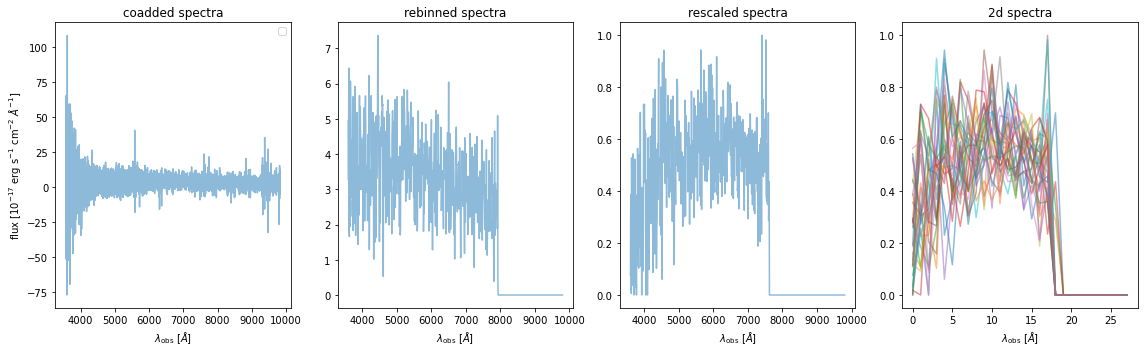

In [31]:
fig, axes = plt.subplots(1,4, figsize=(16,5))

for i in range(6,7):
    
    
    ax = axes[0]
    ax.plot(wavec, fluxc[i], alpha=0.5)

    ax = axes[1]
    ax.plot(host_rewave, host_reflux[i], alpha=0.5)
    
    ax = axes[2]
    ax.plot(host_rewave, host_flux[i], alpha=0.5)
    
    ax = axes[3]
    ax.plot(host_2d[i], alpha=0.5)
    
axes[0].legend(fontsize=10, ncol=2)

axes[0].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
            ylabel=r'flux [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]',
            title='coadded spectra')
axes[1].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
            title='rebinned spectra')
axes[2].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
            title='rescaled spectra')
axes[3].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
            title='Stacked spectra')
fig.tight_layout()

ValueError: x and y must have same first dimension, but have shapes (6265,) and (28, 28)

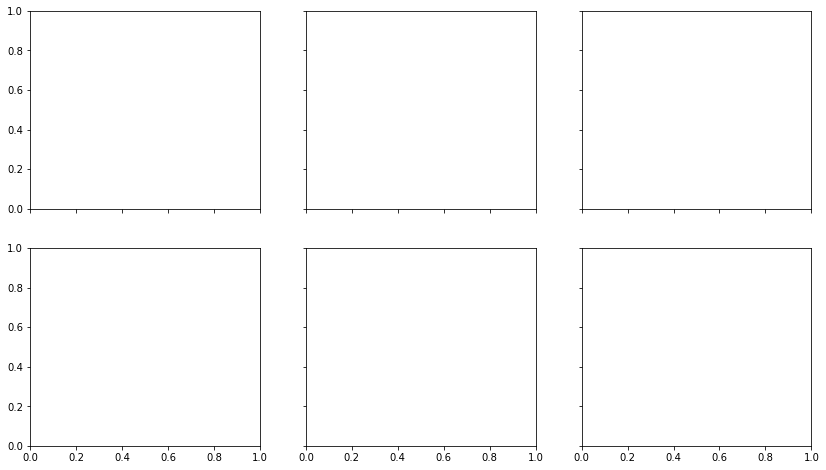

In [17]:
fig, axes = plt.subplots(2,3, figsize=(14,8), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(0,5):
    
    ax = axes[0]
    ax.plot(wave,host_flux[i], alpha=0.5)

    ax = axes[1]
    ax.plot(snia_flux[i], alpha=0.2)
    
    ax = axes[2]
    ax.plot(snib_flux[i], alpha=0.2)
    
    ax = axes[3]
    ax.plot(snic_flux[i], alpha=0.2)
    
    ax = axes[4]
    ax.plot(sniin_flux[i], alpha=0.2)
    
    ax = axes[5]
    ax.plot(sniip_flux[i], alpha=0.2) 
    
    
axes[0].set_title('host spectra')
axes[1].set_title('host + SN Ia spectra')
axes[2].set_title('host + SN Ib spectra')
axes[3].set_title('host + SN Ic spectra')
axes[4].set_title('host + SN IIn spectra')
axes[5].set_title('host + SN IIP spectra')

fig.tight_layout()

### Save the new data

In [12]:
import pickle

with open(r'/global/homes/e/esepeku/DESI-Timedomain/Unbinned/host_flux.data', 'wb') as f:
    pickle.dump(host_flux, f)
    
with open(r'/global/homes/e/esepeku/DESI-Timedomain/Unbinned/snia_flux.data', 'wb') as f:
    pickle.dump(snia_flux, f) 
    
    
with open(r'/global/homes/e/esepeku/DESI-Timedomain/Unbinned/snib_flux.data', 'wb') as f:
    pickle.dump(snib_flux, f) 
        
with open(r'/global/homes/e/esepeku/DESI-Timedomain/Unbinned/snic_flux.data', 'wb') as f:
    pickle.dump(snic_flux, f) 
        
with open(r'/global/homes/e/esepeku/DESI-Timedomain/Unbinned/sniin_flux.data', 'wb') as f:
    pickle.dump(sniin_flux, f) 
     
with open(r'/global/homes/e/esepeku/DESI-Timedomain/Unbinned/sniip_flux.data', 'wb') as f:
    pickle.dump(sniip_flux, f) 
       